<a href="https://colab.research.google.com/github/2019ht12169/Thesis/blob/main/naiveBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

import seaborn as sns

# Load the data files from drive
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)


Mounted at /content/gdrive


In [13]:
train_base_df = pd.read_csv('/content/gdrive/MyDrive/projects/data/dataFile_latest_train.csv') 
test_base_df = pd.read_csv('/content/gdrive/MyDrive/projects/data/dataFile_latest_test.csv') 

# Print a Summary of the Train Data
# Sentiment Classes are labeled either "negative" or "positive"
train_base_df

,label,review_date,text
0,0,2013-03-19,worked well for 1 day the hdmi cable was great...
1,0,2014-01-10,jbl j55 sound quality is okay. but it is very ...
2,0,2014-07-13,expect to buy again soon!! this product was de...
3,0,2013-12-16,it did not work i bought this product and and ...
4,0,2015-05-14,two stars enjoyed but cheaply made broke first...
...,...,...,...
6031,0,2001-05-29,difficult to use i felt the unit had good look...
6032,0,2012-12-09,wrong coverter couldent get it too work with m...
6033,0,2015-03-21,they work. these av cables work well but the p...
6034,0,2013-03-11,okay but nothing fance don't buy these if you ...


In [14]:

# Replace the Classes with Integer Values
train_df = train_base_df.copy()
train_df["label"] = train_df["label"].astype('str')
train_df["label"] = train_df["label"].replace({"0":"negative"})
train_df["label"] = train_df["label"].replace({"1":"positive"})

# Clean the Test Data
test_df = test_base_df.copy()
test_df["label"] = test_df["label"].astype('str')
test_df["label"] = test_df["label"].replace({"0":"negative"})
test_df["label"] = test_df["label"].replace({"1":"positive"})

# Create a Feature based on Text Length
train_df['text_length'] = train_df['text'].str.len() # Store string length of each sample
train_df = train_df.sort_values(['text_length'], ascending=True)
train_df = train_df.dropna()
test_df = test_df.dropna()

train_df.head()

,label,review_date,text,text_length
3544,positive,2015-03-05,junk junk,9
4469,positive,2015-01-12,good good,9
4733,positive,2015-07-18,handy handy,11
3572,positive,2015-01-08,fire so cool,12
4759,positive,2015-01-03,four stars k,12


Text(0, 0.5, 'Labels')

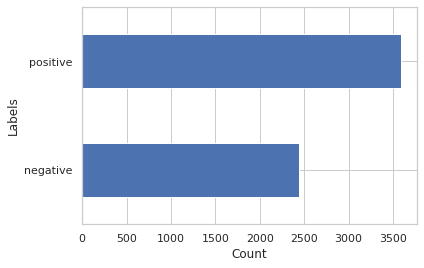

In [15]:
# Print the Distribution of Sentiment Labels
sns.set_theme(style="whitegrid")
ax = train_df['label'].value_counts(sort=False).plot(kind='barh', color='b')
ax.set_xlabel('Count')
ax.set_ylabel('Labels')

Text(0.5, 1.0, 'Text Length Distribution')

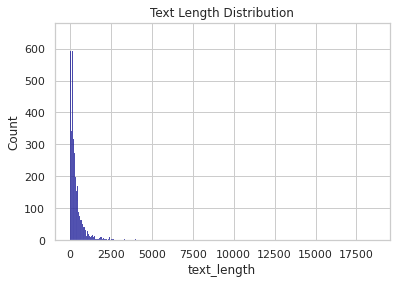

In [23]:

# Visualize a distribution of text_length
sns.histplot(data=train_df, x='text_length', bins='auto',color='darkblue');
plt.title('Text Length Distribution')

              precision    recall  f1-score      support
negative       0.771845  0.771845  0.771845  1236.000000
positive       0.922719  0.922719  0.922719  3649.000000
accuracy       0.884545  0.884545  0.884545     0.884545
macro avg      0.847282  0.847282  0.847282  4885.000000
weighted avg   0.884545  0.884545  0.884545  4885.000000


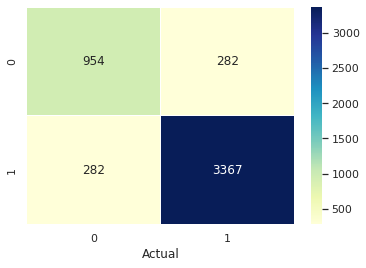

In [24]:
# Create a transformation pipeline
pipeline_log = Pipeline([
                ('count', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(solver='liblinear', multi_class='auto')),
        ])

# Train model using the created sklearn pipeline
model_name = 'logistic regression classifier'
model_lgr = pipeline_log.fit(train_df['text'], train_df['label'])

def evaluate_results(model, test_df):
    # Predict class labels using the learner function
    test_df['pred'] = model.predict(test_df['text'])
    y_true = test_df['label']
    y_pred = test_df['pred']
    target_names = ['negative','positive']

    # Print the Confusion Matrix
    results_log = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    results_df_log = pd.DataFrame(results_log).transpose()
    print(results_df_log)
    matrix = confusion_matrix(y_true,  y_pred)
    sns.heatmap(pd.DataFrame(matrix), 
                annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.xlabel('Predictions')
    plt.xlabel('Actual')
    
    model_score = score(y_pred, y_true, average='macro')
    return model_score

    
# Evaluate model performance
model_score = evaluate_results(model_lgr, test_df)
performance_df = pd.DataFrame().append({'model_name': model_name, 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)

              precision    recall  f1-score      support
negative       0.905292  0.525890  0.665302  1236.000000
positive       0.859371  0.981365  0.916325  3649.000000
accuracy       0.866121  0.866121  0.866121     0.866121
macro avg      0.882332  0.753627  0.790814  4885.000000
weighted avg   0.870990  0.866121  0.852812  4885.000000


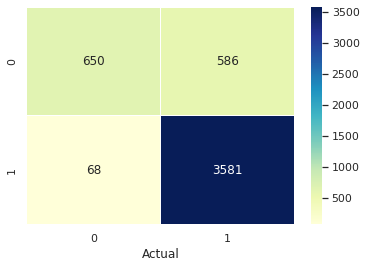

In [25]:
# Create a pipeline which transforms phrases into normalized feature vectors and uses a bayes estimator
model_name = 'bayes classifier'

pipeline_bayes = Pipeline([
                ('count', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('gnb', MultinomialNB()),
                ])

# Train model using the created sklearn pipeline
model_bayes = pipeline_bayes.fit(train_df['text'], train_df['label'])

# Evaluate model performance
model_score = evaluate_results(model_bayes, test_df)
performance_df = performance_df.append({'model_name': model_name, 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)

   f1_score                      model_name  precision    recall
0  0.847282  logistic regression classifier   0.847282  0.847282
1  0.753627                bayes classifier   0.882332  0.790814


Text(0.5, 1.0, 'Model Outlier Detection Performance (Macro)')

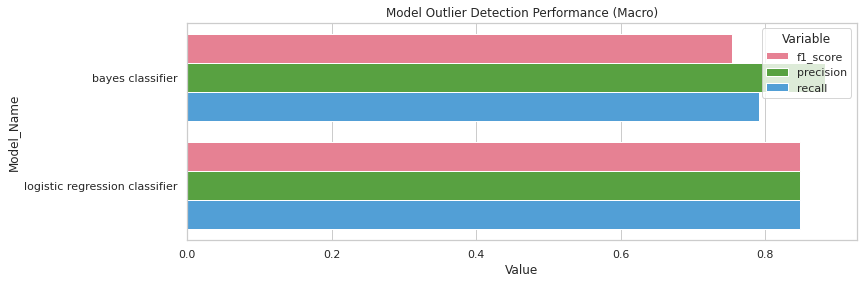

In [26]:
# Compare model performance
print(performance_df)

performance_df = performance_df.sort_values('model_name')
fig, ax = plt.subplots(figsize=(12, 4))
tidy = performance_df.melt(id_vars='model_name').rename(columns=str.title)
sns.barplot(y='Model_Name', x='Value', hue='Variable', data=tidy, ax=ax, palette='husl',  linewidth=1, edgecolor="w")
plt.title('Model Outlier Detection Performance (Macro)')

In [27]:
testphrases = ['Mondays just suck!', 'I love this product', 'That is a tree', 'Terrible service']
for testphrase in testphrases:
    resultx = model_lgr.predict([testphrase]) # use model_bayes for predictions with the other model
    print(testphrase + '-> ' + resultx[0])

Mondays just suck!-> positive
I love this product-> positive
That is a tree-> positive
Terrible service-> negative
